# Predicting NVIDIA Stock (NVDA) Prices With RNNs

## Objective

As the title suggests, the models trained in this notebook will be trained for the purpose of predicting daily NVIDIA stock prices.

We will be training three variations of recurrent neural networks (RNNs) to compare the accuracy of predictions, ultimately determining the one best suited for this problem.

Our means of determining suitability of our models for this problem will be quite simple. We will assess them by utilizing both mean-squared error and mean-absolute error, as well as visually determining adherence of predicted values to the actual values using a time-series k-fold validation approach.

The three variations of RNNs we will be training are: simple RNN, LSTM, and bi-directional RNN.

## Preparation

In this section, we will be performing our initial steps, as well as preparing our dataset for the model training.

### Import Necessary Libraries

In [3]:
import os
import datetime as dt
from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sbn

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # limits the amount of warnings displayed in cell output

### Helper Functions

`str_to_date` is used to convert the original 'Date' column of our dataset from a string into a datetime object.

In [4]:
def str_to_date(date_str):
    return dt.datetime.strptime(date_str, '%d-%m-%Y')

`days_in_month` will determine the number of days in a given month.

This function is used to help perform some feature engineering using our 'Date' column.

In [5]:
def days_in_month(row) -> int:
    days_in_each_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    month = row['month'] + 1
    year = row['year']

    if month == 2:
        if year % 4 == 0 and year % 100 != 0 or year % 400 == 0:
            return 29
        else:
            return 28
        
    return days_in_each_month[month - 1]

`prepare_split` will be used to take our data for a fold and shape it properly for our RNNs.

In [6]:
def prepare_split(data: pd.DataFrame, timesteps: int):
    feature_cols = [col for col in data.columns if col not in target_cols]
    
    X = data[feature_cols].values
    y = data[target_cols].values

    X_reshape = []
    y_reshape = []

    for i in range(timesteps, len(X)):
        X_reshape.append(X[i-timesteps:i])
        y_reshape.append(y[i])

    X_reshape = np.array(X_reshape)
    y_reshape = np.array(y_reshape)

    X_tensor = tf.convert_to_tensor(X_reshape, dtype=tf.float64)
    y_tensor = tf.convert_to_tensor(y_reshape, dtype=tf.float64)

    return X_tensor, y_tensor

`rescale_values` will rescale our prices back to their original scale. We will use this to plot the predicted prices against the actual prices for each test fold.

In [7]:
def rescale_values(y: tf.Tensor, scaler):
    # Extract the last timestep's prediction or actual value (shape: (1025, 1))
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    # Create an array with the same number of columns as the original scaled columns
    orig_dims = np.zeros( ( len(y), len(scale_cols) ) )
    
    # Assign the values of the last timestep to the 'Close' column (assumed to be index 3)
    orig_dims[:, 3] = y[:, 0].flatten()
    
    # Inverse transform using the scaler
    orig_dims_rescaled = scaler.inverse_transform(orig_dims)
    
    # Return the rescaled 'Close' values
    return orig_dims_rescaled[:, 3]

`plot_model_performance` will plot the loss progression during each training set, as well as the predicted prices against the actual prices for each test set.

In [8]:
def plot_model_performance(batch_losses, y_pred_rescaled, y_test_rescaled):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # Plot batch-wise loss progression
    axs[0].plot(batch_losses)
    axs[0].set_title('Batch-wise Loss Progression (train set)')
    axs[0].set_xlabel('Batch')
    axs[0].set_ylabel('Loss')

    # Plot actual vs predicted stock prices
    axs[1].plot(y_test_rescaled, label='Actual', color='blue')
    axs[1].plot(y_pred_rescaled, label='Predicted', color='red', linestyle='dotted')
    axs[1].set_title('Actual vs Predicted Stock Prices (test set)')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Scaled Stock Price (Close)')
    axs[1].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

### The Dataset

The dataset we will be using is the [Nvidia Stocks Data - Latest 21 September](https://www.kaggle.com/datasets/kpatel00/nvidia-stocks-data-latest-25-august-2024?select=NvidiaStockPrice.csv) provided on Kaggle.

This dataset contains historical stock prices for NVDA, ranging from January 1999 to September 2024.

Each sample in the dataset contains a small variety of data regarding the prices for that day.

The features included in the dataset are as follows:

- Date      : Date of the trading day

- Open      : stock price at market open

- High      : highest stock price during the trading day

- Low       : lowest stock price of the trading day

- Close     : stock price at market close

- Adj Close : adjusted stock price at market close, accounting for dividends and stock splits

- Volume    : Number of shares traded for the dau

In [9]:
df = pd.read_csv(r"./archive/NvidiaStockPrice.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,22-01-1999,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1,25-01-1999,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
2,26-01-1999,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
3,27-01-1999,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
4,28-01-1999,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6453.000000,6453.000000,6453.000000,6453.000000,6453.000000,6.453000e+03
mean,6.746678,6.874758,6.609043,6.748384,6.722143,6.048921e+08
std,17.829169,18.179203,17.430172,17.822201,17.825521,4.316393e+08
min,0.034896,0.035547,0.033333,0.034115,0.031291,1.968000e+07
25%,0.278250,0.286500,0.270667,0.277500,0.254530,3.448400e+08
50%,0.459250,0.466500,0.452750,0.459500,0.430026,5.057760e+08
75%,4.263250,4.314000,4.191750,4.254500,4.216072,7.352060e+08
max,139.800003,140.759995,132.419998,135.580002,135.580002,9.230856e+09


#### Data Preprocessing

Before we perform any adjustments to our dataframe, let's take a copy of it so we can retain the original.

We will also be dropping the 'Adj Close' column. Because this column depends on the 'Close' value quite heavily, there is a strong likelihood that it would result in data leakage during training.

In [11]:
# create a copy of the original dataframe to perform transformations on,
dfc = df.copy()
dfc.drop('Adj Close', axis=1, inplace=True)  # to prevent data leakage

Next, we convert the strings in our 'Date' column into datetime objects.

This will help tremendously with feature engineering.

In [12]:
# convert the date string to a datetime object
dfc['Date'] = dfc['Date'].apply(str_to_date)

Due to the sensitivity of RNNs to the magnitude of feature values, we will require some scaling. 
To prepare for this, we create a list containing each of the features we will be scaling (all except for 'Date')

We will need to apply the scaling in each fold of our training loop, so the scaling will occur in our training function.

We will also go ahead and convert our 'Volume' column to a float, which we will need to do before our scaling occurs.

In [13]:
target_cols = ['Close']

scale_cols = [f for f in dfc.columns if f != "Date"]
scale_cols
print(scale_cols)

dfc['Volume'] = dfc['Volume'].astype('float64')

['Open', 'High', 'Low', 'Close', 'Volume']


For some easy feature engineering, we can create some new columns from our datetime object:

- `day_of_week` : The day of the week (Monday, Tuesday, etc.)

- `day_of_month` : The day of the month (0-indexed)

- `month` : the month of the sample (0-indexed)

- `year` : the year of the sample

- `week_of_year` : the week of the year (0-indexed; out of 52)

- `quarter` : the quarter the sample resides in (0-indexed)

- `is_weekend` : whether the trade occurred on the weekend or not

These new features will help our model in identifying a wider range of trends.

In [14]:
# extract various additional features from our datetime 
dfc['day_of_week']  = dfc['Date'].dt.dayofweek
dfc['day_of_month'] = dfc['Date'].dt.day - 1
dfc['month']        = dfc['Date'].dt.month - 1
dfc['year']         = dfc['Date'].dt.year
dfc['week_of_year'] = dfc['Date'].dt.isocalendar().week - 1
dfc['quarter']      = dfc['Date'].dt.quarter - 1
dfc['is_weekend']   = dfc['Date'].dt.weekday >= 5

Since dates are cyclic, it will help to encode them as such to provide more accurate and interpretable patterns across date barriers. 

Such barriers include: Saturday is close to Sunday, the end of one month is close to the next, December is close to January, etc.

Not all features related to the date of the sample will be encoded this way. For example, it is meaningless to cyclically encode the year.

In [15]:
# perform cyclic encoding on 'day_of_week'
dfc['day_of_week_sin'] = np.sin( 2*np.pi * dfc['day_of_week'] / 7 )
dfc['day_of_week_cos'] = np.cos( 2*np.pi * dfc['day_of_week'] / 7 )

# perform cyclic encoding on 'day_of_month'
dfc['days_in_month'] = dfc.apply(days_in_month, axis=1)  # temporarily add a days_in_month column
dfc['day_of_month_sin'] = np.sin( 2*np.pi * dfc['day_of_month'] / dfc['days_in_month'] )
dfc['day_of_month_cos'] = np.cos( 2*np.pi * dfc['day_of_month'] / dfc['days_in_month'] )

# perform cyclic encoding on 'month'
dfc['month_sin'] = np.sin( 2*np.pi * dfc['month'] / 12 )
dfc['month_cos'] = np.cos( 2*np.pi * dfc['month'] / 12 )

# perform cyclic encoding on 'week_of_year'
dfc['week_of_year_sin'] = np.sin( 2*np.pi * dfc['week_of_year'] / 52 )
dfc['week_of_year_cos'] = np.cos( 2*np.pi * dfc['week_of_year'] / 52 )

# perform cyclic encoding on 'quarter'
dfc['quarter_sin'] = np.sin( 2*np.pi * dfc['quarter'] / 4 )
dfc['quarter_cos'] = np.cos( 2*np.pi * dfc['quarter'] / 4 )

Lastly, we drop the original columns after encoding. Keeping them defeats the purpose of the encoding.

In [16]:
# drop our original, non-encoded columns
dfc.drop(
    ['day_of_week', 'day_of_month', 'month', 'week_of_year', 'quarter', 'days_in_month'], 
    axis=1, 
    inplace=True)

dfc.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,6453,2011-11-18 02:41:06.945606656,1999-01-22 00:00:00,2005-06-22 00:00:00,2011-11-15 00:00:00,2018-04-17 00:00:00,2024-09-13 00:00:00,NaN
Open,6453.0,6.746678,0.034896,0.27825,0.45925,4.26325,139.800003,17.829169
High,6453.0,6.874758,0.035547,0.2865,0.4665,4.314,140.759995,18.179203
Low,6453.0,6.609043,0.033333,0.270667,0.45275,4.19175,132.419998,17.430172
Close,6453.0,6.748384,0.034115,0.2775,0.4595,4.2545,135.580002,17.822201
Volume,6453.0,604892102.60344,19680000.0,344840000.0,505776000.0,735206000.0,9230856000.0,431639269.545042
year,6453.0,2011.381528,1999.0,2005.0,2011.0,2018.0,2024.0,7.405686
day_of_week_sin,6453.0,0.360945,-0.433884,0.0,0.433884,0.781831,0.974928,0.515759
day_of_week_cos,6453.0,-0.093256,-0.900969,-0.900969,-0.222521,0.62349,1.0,0.771458
day_of_month_sin,6453.0,0.008443,-1.0,-0.724793,0.0,0.724793,1.0,0.708299


Our dataset is looking much more flushed out, and our features are all scaled appropriately for our model.

Just to confirm, let's see if any of the samples from our dataset occurred on a weekend.

In [17]:
dfc['is_weekend'].unique()

array([False])

Since we don't have any weekend trades in our dataset, the `is_weekend` column isn't useful to us. So we drop it.

In [18]:
if 'Date' in dfc.columns and 'is_weekend' in dfc.columns:
    dfc = dfc.drop(['Date', 'is_weekend'], axis=1)
dfc.head()

,Open,High,Low,Close,Volume,year,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
0,0.043750,0.048828,0.038802,0.041016,2.714688e+09,1999,-0.433884,-0.900969,-0.897805,-0.440394,0.0,1.0,0.239316,0.970942,0.0,1.0
1,0.044271,0.045833,0.041016,0.045313,5.104800e+08,1999,0.000000,1.000000,-0.988468,0.151428,0.0,1.0,0.354605,0.935016,0.0,1.0
2,0.045833,0.046745,0.041146,0.041797,3.432000e+08,1999,0.781831,0.623490,-0.937752,0.347305,0.0,1.0,0.354605,0.935016,0.0,1.0
3,0.041927,0.042969,0.039583,0.041667,2.443680e+08,1999,0.974928,-0.222521,-0.848644,0.528964,0.0,1.0,0.354605,0.935016,0.0,1.0
4,0.041667,0.041927,0.041276,0.041536,2.275200e+08,1999,0.433884,-0.900969,-0.724793,0.688967,0.0,1.0,0.354605,0.935016,0.0,1.0


## Model Training

Before we get into creating and training our models, we're going to set up a model-agnostic training loop. 

In short, our training function will take a model and various hyper parameters, and train the model across a number of `TimeSeriesSplit`s.

Each split will retain the chronological order of the samples, and begin from the same starting point (Jan 22, 1999). Where the splits differ, is that each split will be wider than the previous. The training data will go up to a certain point in that split, and then the testing data will be the remaining 20% of the samples, allowing us to predict on data in the future compared to the training data. 

Due to the nature of `TimeSeriesSplit`, our training function will return the model after it has trained on the final fold, which has the widest time-range.

For each fold, the function will output the loss progression during the training phase, and plot the predicted vs. actual prices (rescaled to that of the original dataset).

`train_model` will take the following arguments:

- `model_init` : the function that initializes a model

- `splits` : the number of time-series folds (training and testing) to split our dataset into

- `epohcs` : the number of passes through the entire training fold

- `batch_size` : the number of timestep samples to pass to the model in a batch

- `timesteps` : the number of samples to include in each sequence

- `verbose` : the degree to which keras displays the training/testing progression

- `**model_kwargs` : the parameters to pass to the `model_init` function when creating the model

For each fold, we will output the mean-squared error and the mean-absolute error, as well as plot the loss progression during the training set, and the predictions made on the test data next their actual values.

In [19]:
# this class will retain the losses for each batch throughout the training sets
#   (used for plotting)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

def train_model(
        model_init,
        splits: int,
        epochs: int,
        batch_size: int,
        timesteps: int,
        verbose,
        **model_kwargs
):
    final_model = None
    data_splits = TimeSeriesSplit(n_splits=splits)
    for fold, (train_idx, test_idx) in enumerate(data_splits.split(dfc)):
        train_data, test_data = dfc.iloc[train_idx], dfc.iloc[test_idx]

        # perform min-max scaling on our price columns
        mm = MinMaxScaler()
        train_data.loc[:, scale_cols] = mm.fit_transform(train_data[scale_cols])
        test_data.loc[:, scale_cols]  = mm.transform(test_data[scale_cols])

        X_train, y_train = prepare_split(train_data, timesteps)
        X_test, y_test   = prepare_split(test_data, timesteps)

        model = model_init(**model_kwargs)

        loss_history = LossHistory()

        model.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[loss_history],
                    verbose=verbose)
        
        batch_losses = loss_history.batch_losses

        y_pred = model.predict(X_test)

        y_test_rescaled = rescale_values(y_test, mm)
        y_pred_rescaled = rescale_values(y_pred, mm)

        eval = model.evaluate(X_test, y_test)
        print(f"Fold-{fold+1} evaluation: \n{eval}")
        
        # if fold+1 == splits:
        #     display(train_data.describe())
        #     display(test_data.describe())
        plot_model_performance(batch_losses, y_pred_rescaled, y_test_rescaled)

        if fold+1 == splits:
            final_model = model

    return final_model if final_model is not None else None

### Simple RNN

Below, we have our function that instantiates our simple RNN model. 

It takes various model parameters as arguments, and outputs a model which contains our input layer, a single `SimpleRNN` layer, and a `Dense` layer the width of the number of targets.

In [20]:
def simple_rnn_init(
        units: int,
        activation: str,
        return_sequences: bool,
        input_shape: tuple,
        optimizer,
        learning_rate,
        loss: str
):
    simple_rnn = Sequential()
    simple_rnn.add(Input(shape=input_shape))
    simple_rnn.add(SimpleRNN(
        units=units,
        activation=activation,
        return_sequences=return_sequences
    ))
    simple_rnn.add(Dense(len(target_cols)))
    simple_rnn.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=['mae'])
    return simple_rnn

#### Training

Finally we get to train our first model!

I have done some manual testing prior to submitting this notebook, and determined these hyperparameters to be acceptable for our tests.

Keep in mind that the output you see is progressive, in that, while the model is reinitialized for each fold, each fold contains a wider time-range than the previous fold, and they all begin at the same starting sample. This means that we should expect the error to go down with each successive fold, and the final plot should be the most accurate.

The testing data occurs after the training set chronologically, so the predictions you are seeing for each fold's testing data are all future days compared to the respective training set.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1974 - mae: 0.3680
Fold-1 evaluation: 
[0.13430991768836975, 0.2817097306251526]


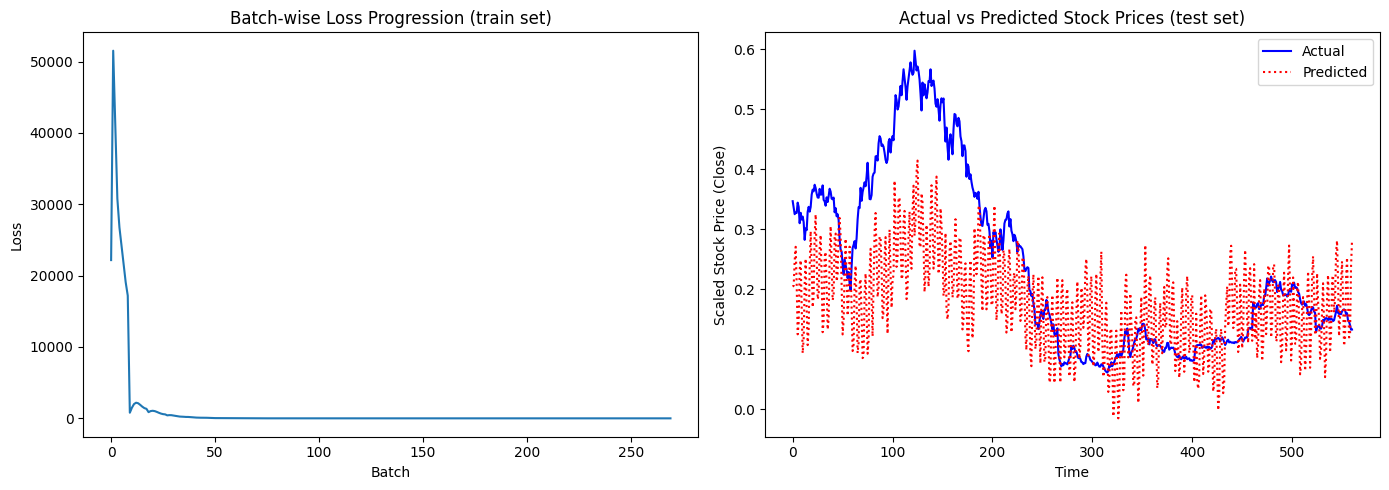

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0131 - mae: 0.0940
Fold-2 evaluation: 
[0.023328393697738647, 0.12545768916606903]


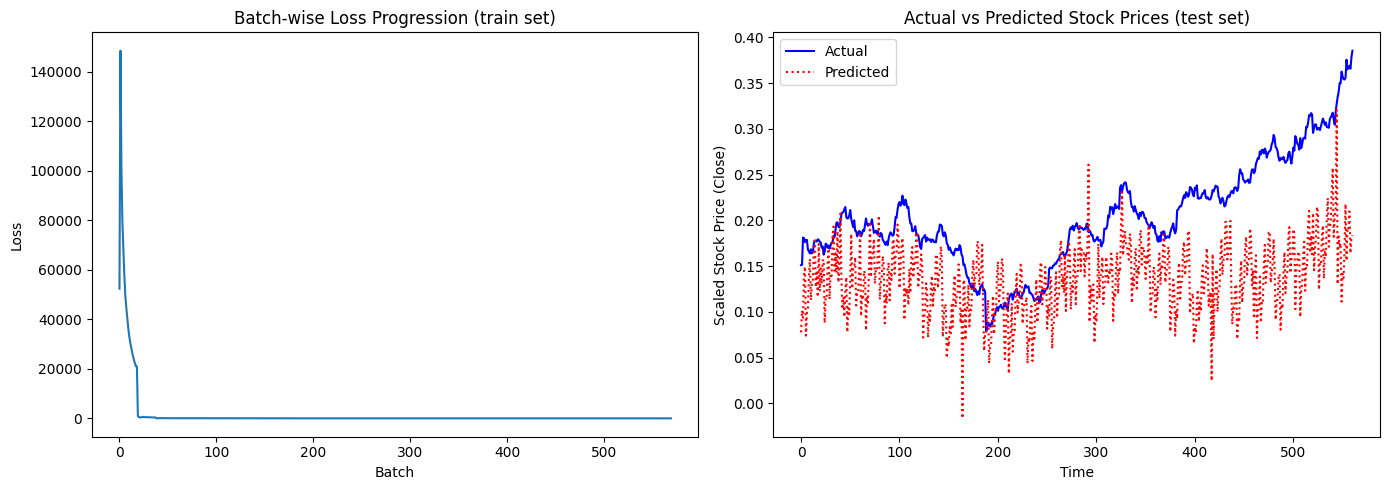

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2914 - mae: 0.4988
Fold-3 evaluation: 
[0.4324006140232086, 0.6098790764808655]


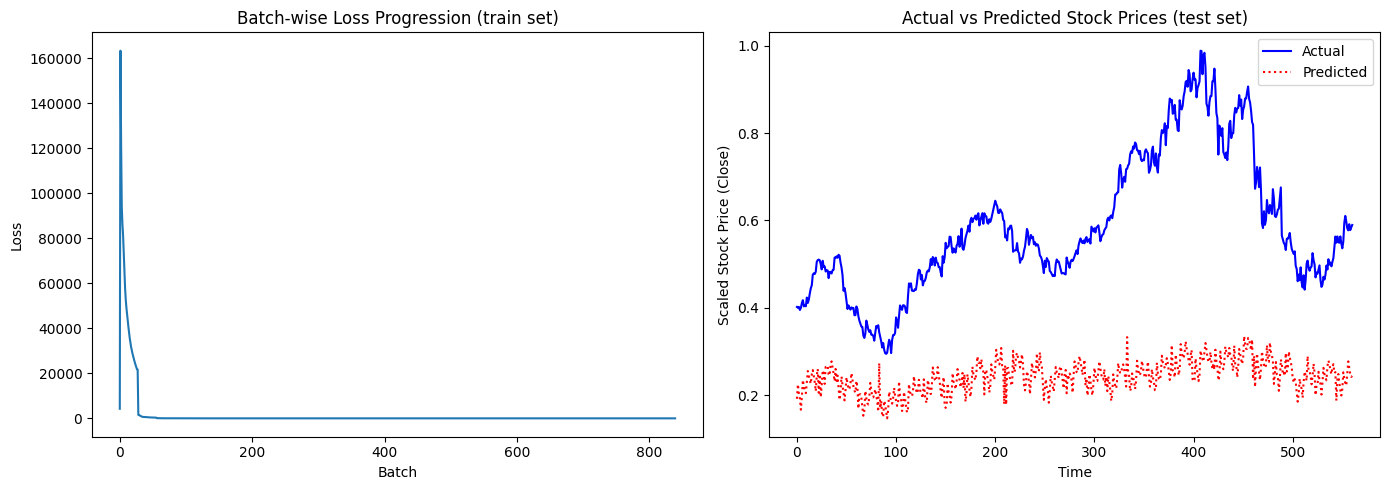

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - mae: 0.0264
Fold-4 evaluation: 
[0.0010815723799169064, 0.02466217242181301]


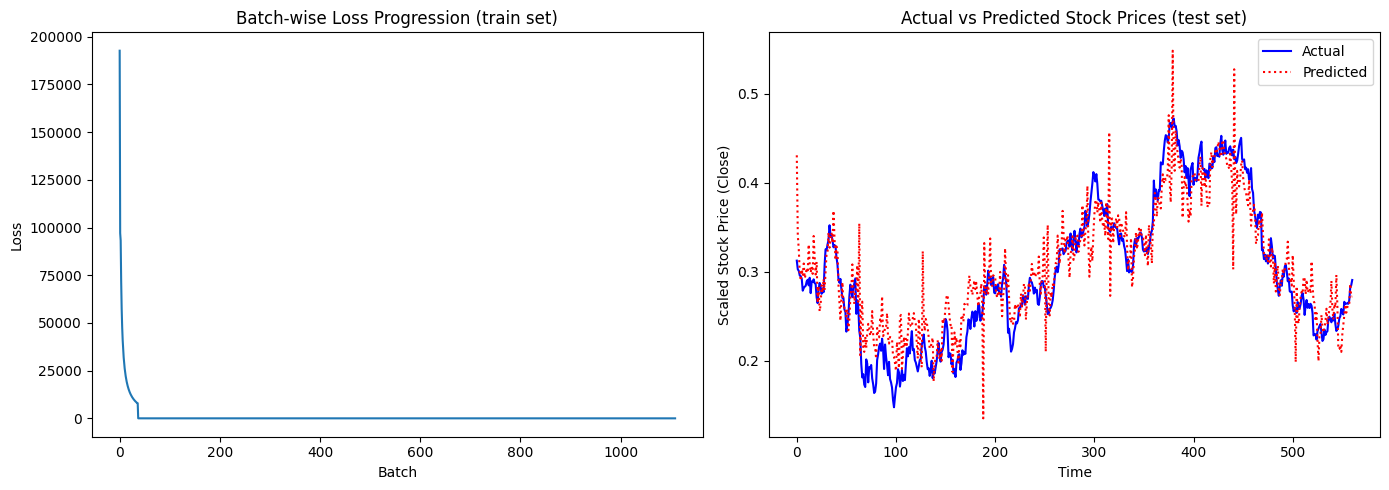

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0109 - mae: 0.0802
Fold-5 evaluation: 
[0.008628704585134983, 0.06827839463949203]


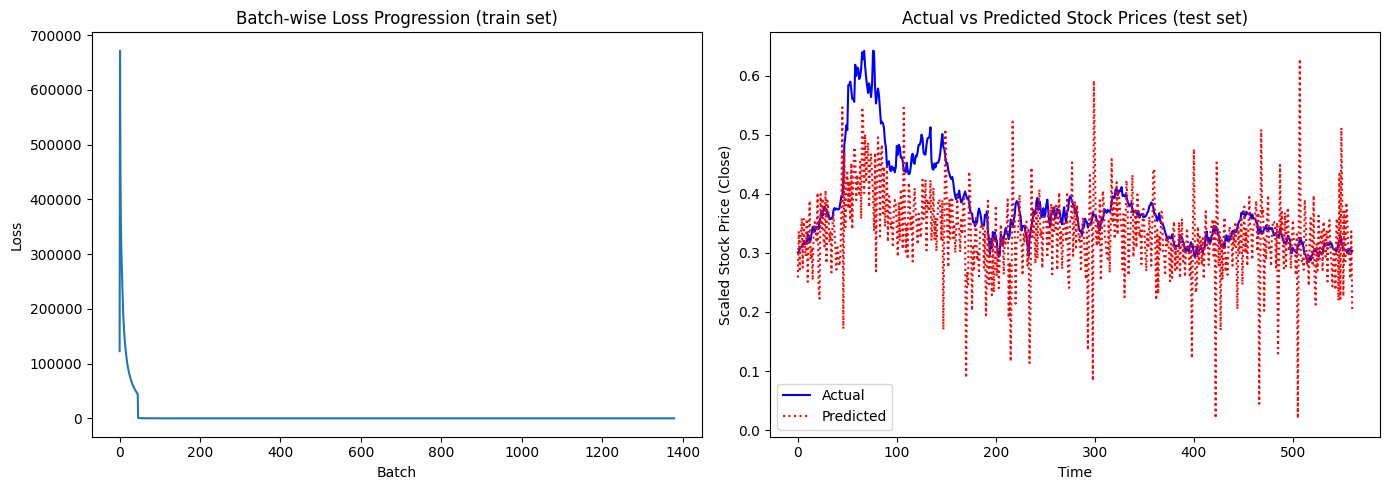

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - mae: 0.0870
Fold-6 evaluation: 
[0.006548906210809946, 0.06824423372745514]


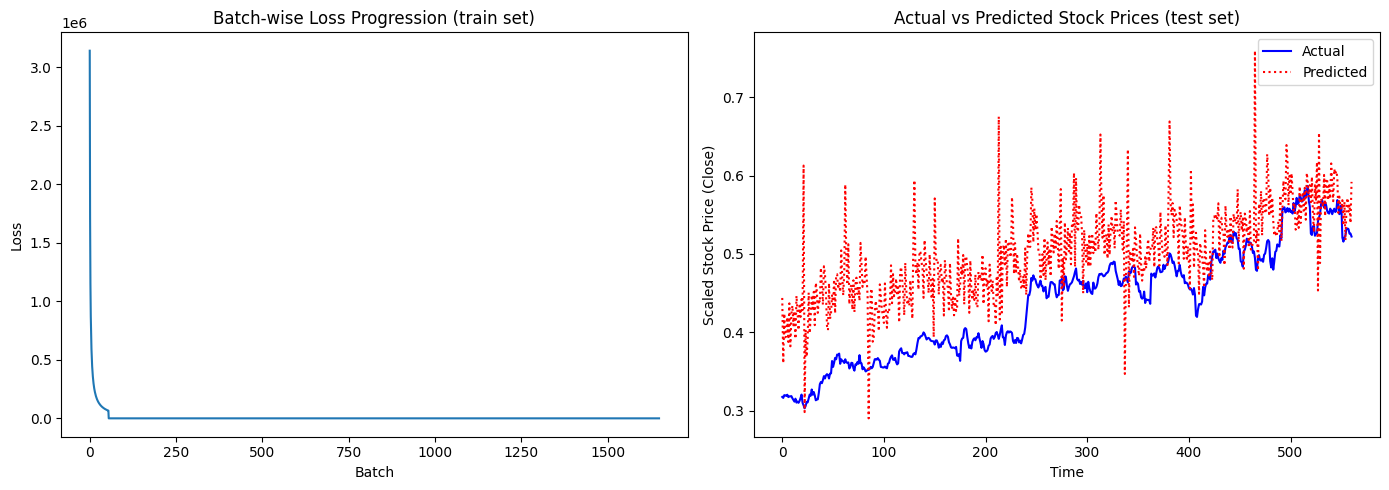

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8841 - mae: 0.7780
Fold-7 evaluation: 
[2.357903242111206, 1.2992926836013794]


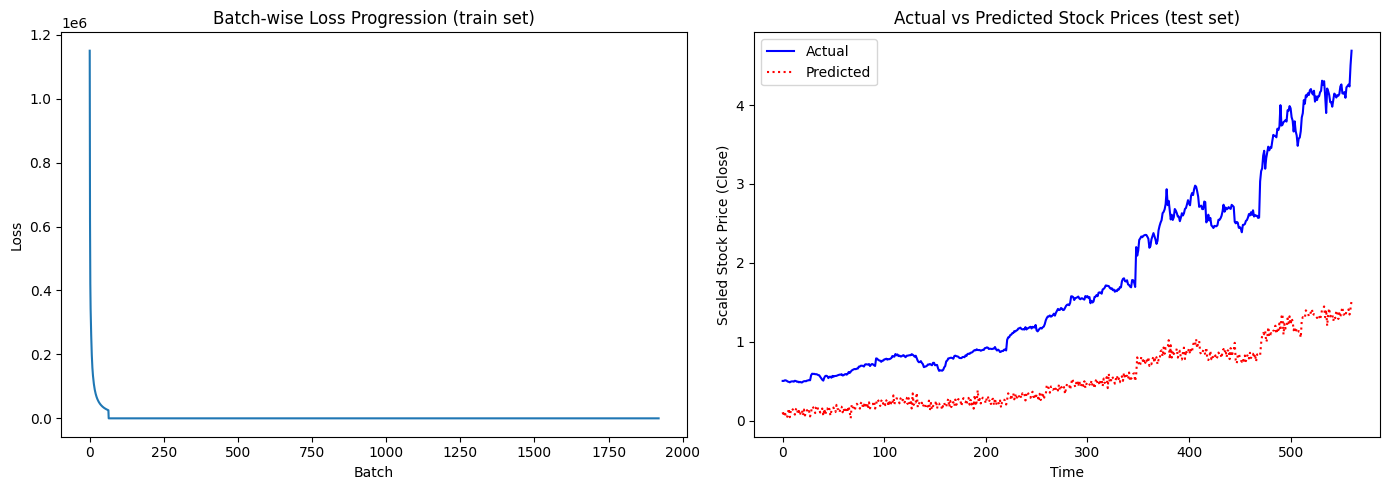

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0703 - mae: 0.2539
Fold-8 evaluation: 
[0.06256372481584549, 0.2372211366891861]


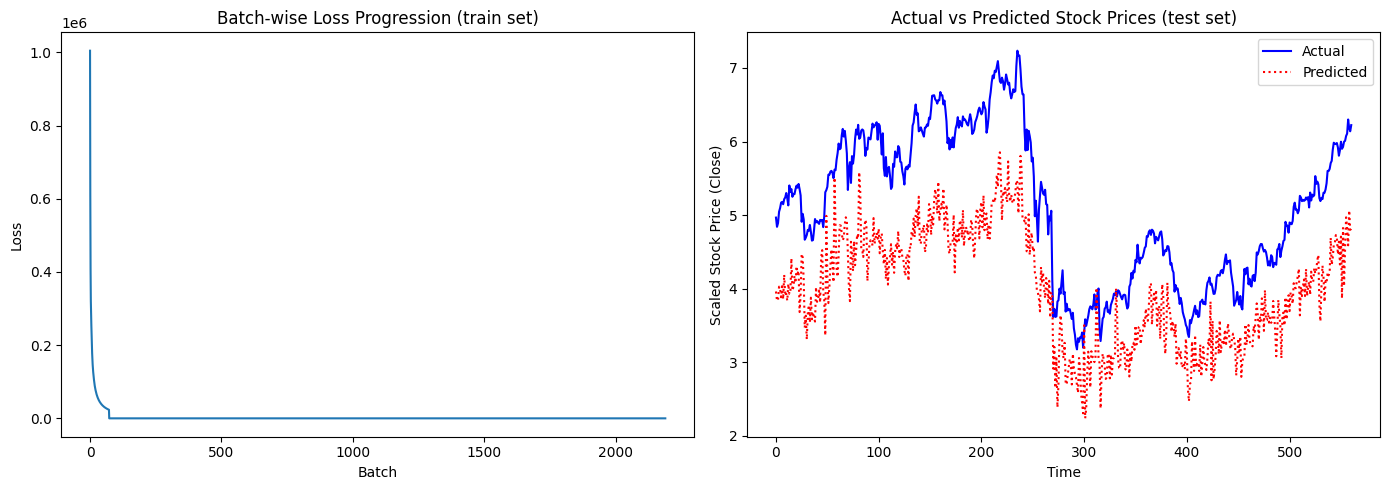

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0540 - mae: 0.1983
Fold-9 evaluation: 
[0.10508062690496445, 0.2826230227947235]


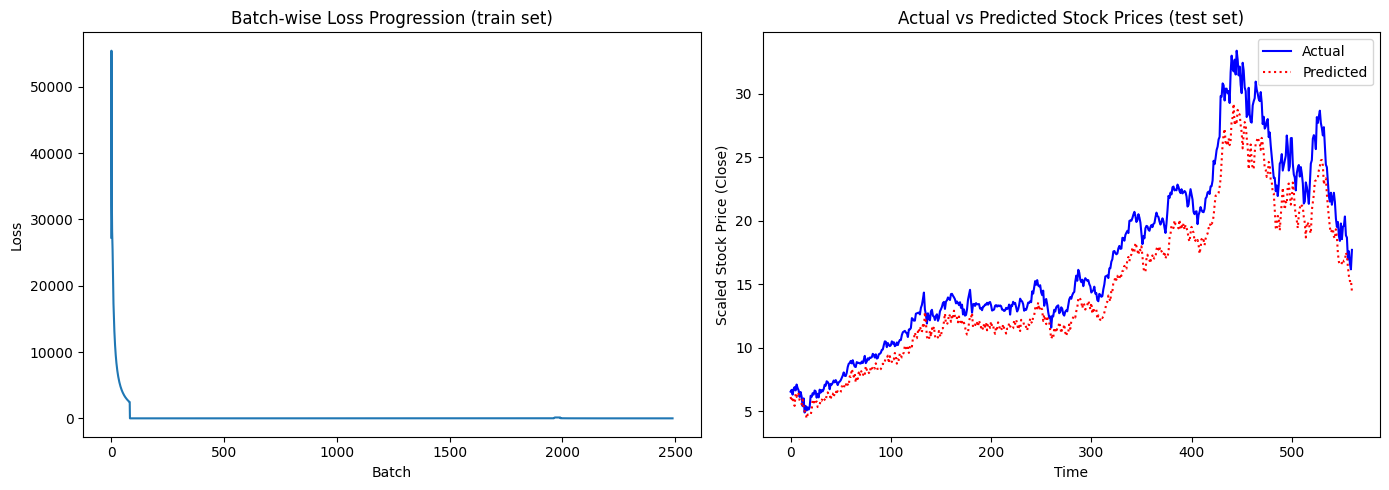

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0258 - mae: 0.0993
Fold-10 evaluation: 
[0.0879497155547142, 0.21557766199111938]


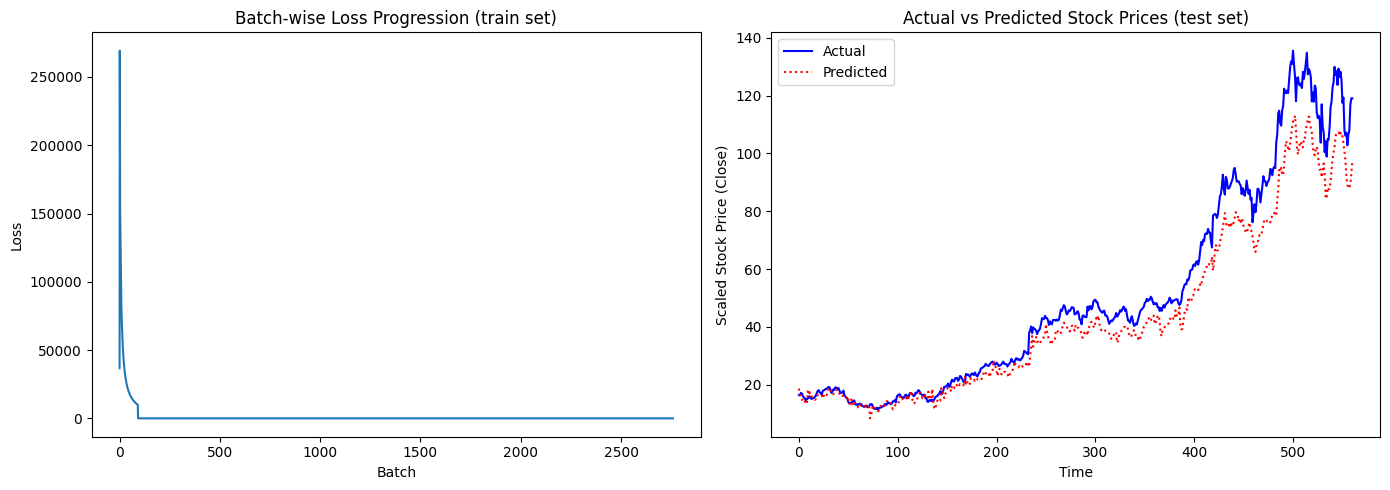

In [22]:
timesteps = 25

simple_rnn_kwargs = {
    'units': 50,
    'activation': "relu",
    'return_sequences': False,
    'input_shape': ( timesteps, dfc.shape[1] - len(target_cols) ),
    'optimizer': Adam,
    'learning_rate': 0.01,
    'loss': 'mse'
}

simple_rnn_model = train_model(
                        model_init=simple_rnn_init,
                        splits=10,
                        epochs=30,
                        batch_size=64,
                        timesteps=timesteps,
                        verbose=0,
                        **simple_rnn_kwargs)

#### Discussion

Very exciting results from our first test with the simple RNN!

While the simplest model of the three we will be testing today, it ended up performing quite well in the end.

Keep in mind, however, that the errors shown above the plots are scaled for our preprocessed data, while the predicted values plots are returned to the original scale. Since we used the min-max scaler, our mean-absolute error of ~0.14 indicates that we were off by about 14% on average across all our predictions. A fairly significant error rate.

Our predictions in the earlier folds were quite erratic, and we even had some nonsensical predictions, such as negative prices.

We do see that our model was able to pick up on the patterns quite well, and as early as fold 5 (half-way through our dataset). A pretty impressive feat for a single-layer simple RNN model.

### LSTM

The second model we will be training in this notebook is a single-layer LSTM model. 

Given the increased sophistication compared to the simple RNN, we should expect this model to perform better than our simple RNN.

You may notice some additional arguments passed to the LSTM model that we did not for the simple RNN model (e.g. `kernal_regularizer`, `recurrent_regularizer`). This will be explained in the next section.

In [23]:
from keras.regularizers import L1, L2, L1L2

def lstm_init(
        units: int,
        activation: str,
        recurrent_activation: str,
        return_sequences: bool,
        input_shape: tuple,
        optimizer,
        learning_rate,
        dropout,
        recurrent_dropout,
        loss: str
):
    lstm = Sequential()
    lstm.add(Input(shape=input_shape))
    lstm.add(LSTM(
        units=units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        return_sequences=return_sequences,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        kernel_regularizer=L2(0.005),
        recurrent_regularizer=L2(0.005),
        bias_regularizer=None,
        unroll=False,
    ))
    lstm.add(Dense(len(target_cols)))
    lstm.compile(optimizer=optimizer(learning_rate=learning_rate), 
                 loss=loss, 
                 metrics=['mae'])
    return lstm

#### Training

We deviated from the hyperparameters we had before, since it was difficult to get the performance of the LSTM model even remotely close to the simple RNN we trained before with similar hyperparameters. Aside from the changes to the introduced regularization above, the number of epochs, and the learning rate, we will be keeping all else the same as the previous model training.

Needing significantly different hyperparameters may be expected, since LSTM models are more sensitive to hyperparameter tuning compared to simple RNN.

We train for many more epochs than before, with a more refined learning rate, in hopes of getting some reasonable performance.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0418 - mae: 0.1030
Fold-1 evaluation: 
[0.03780275583267212, 0.08935106545686722]


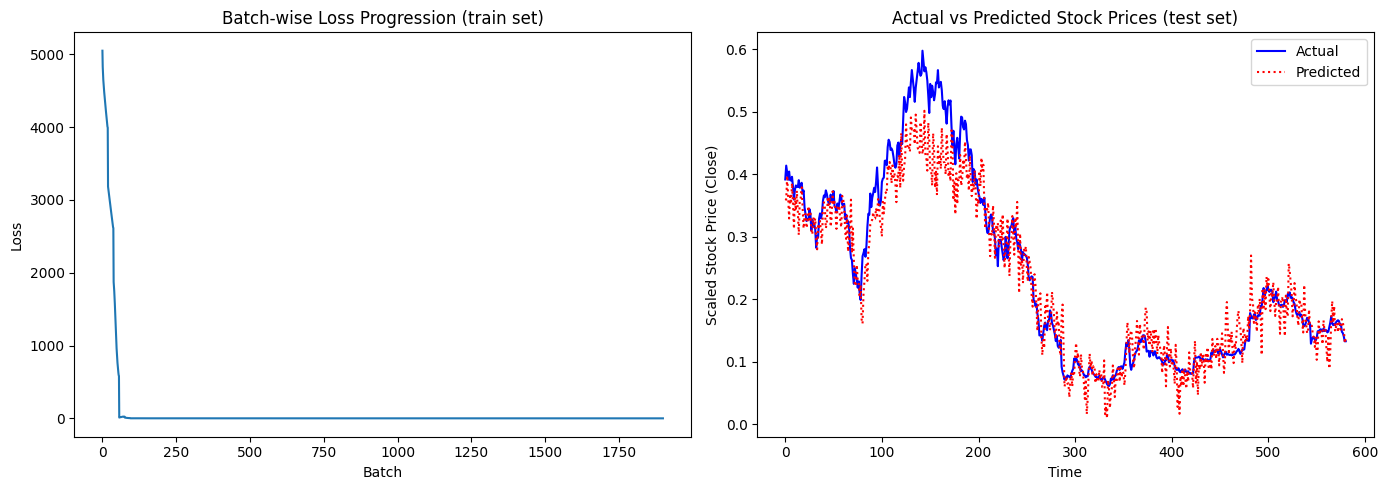

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0223 - mae: 0.0566
Fold-2 evaluation: 
[0.022238144651055336, 0.05608343705534935]


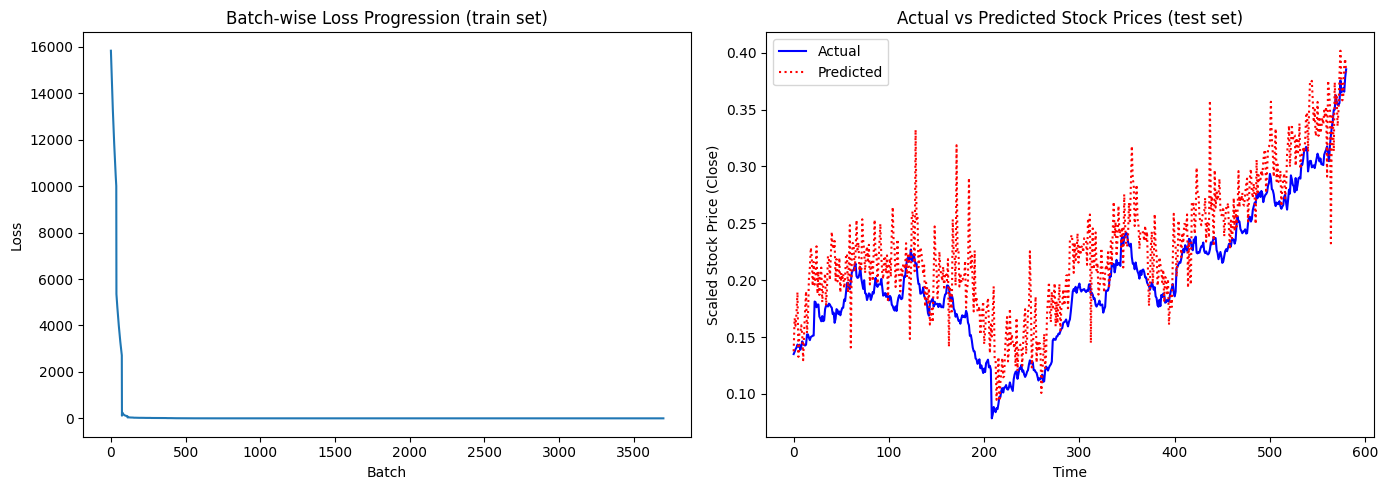

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0318 - mae: 0.0714
Fold-3 evaluation: 
[0.03321639820933342, 0.07812679558992386]


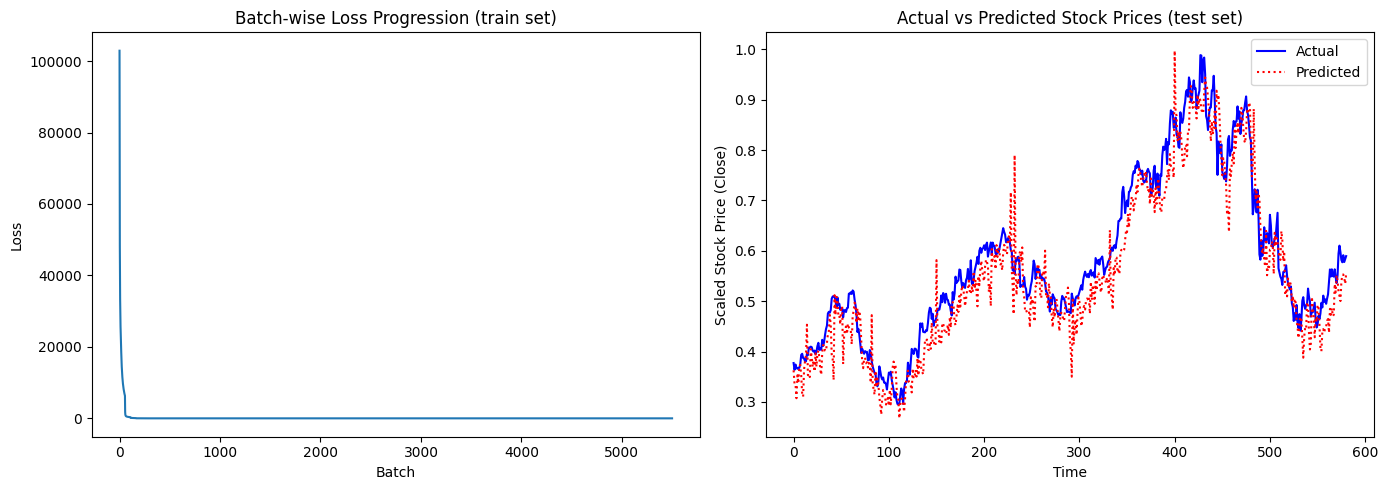

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - mae: 0.0239
Fold-4 evaluation: 
[0.004706446547061205, 0.024512140080332756]


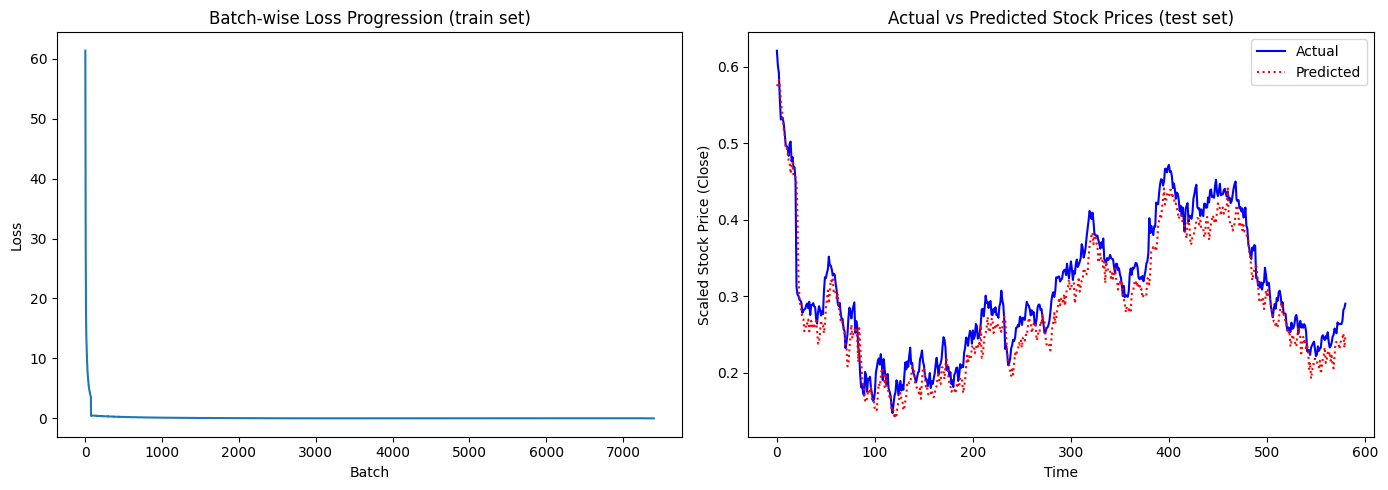

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0365 - mae: 0.0862
Fold-5 evaluation: 
[0.033608801662921906, 0.07536373287439346]


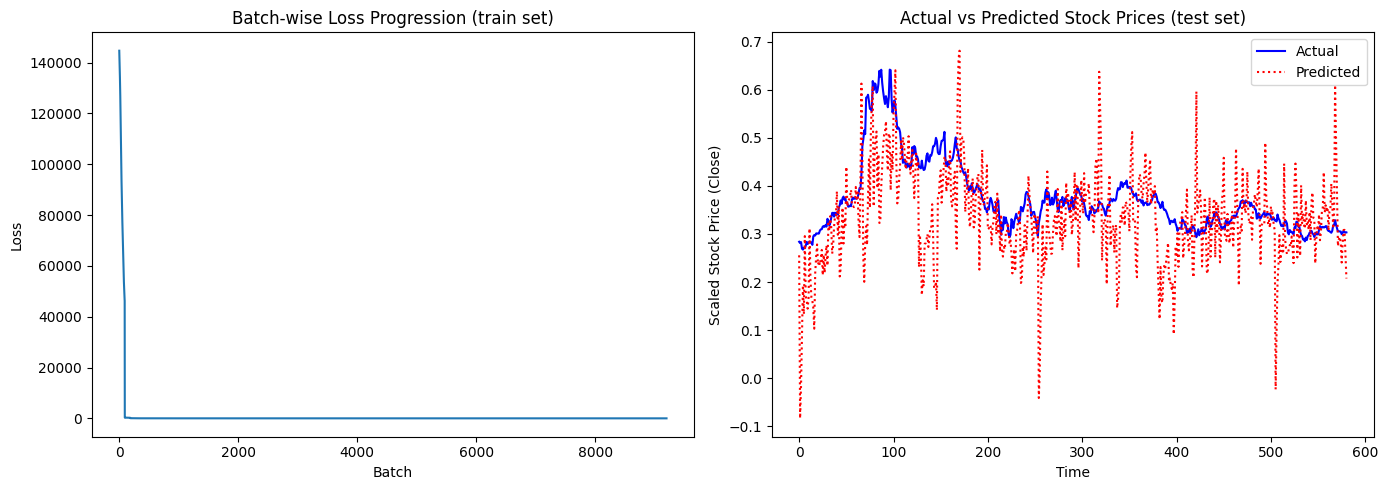

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0181 - mae: 0.0909
Fold-6 evaluation: 
[0.017966214567422867, 0.08933170884847641]


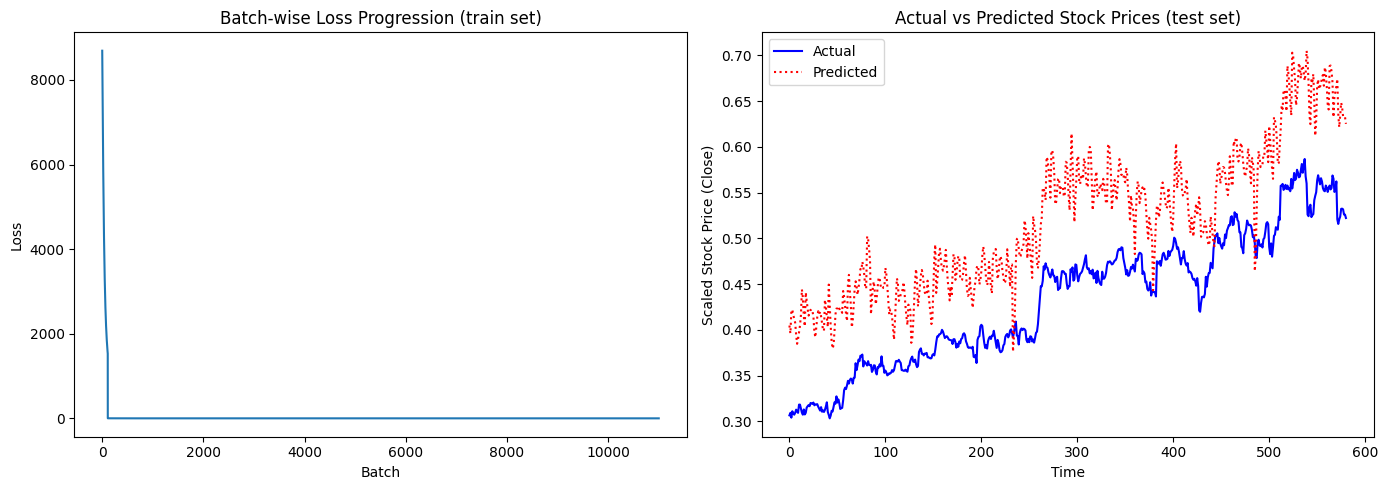

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1231 - mae: 0.3038
Fold-7 evaluation: 
[0.194760262966156, 0.35047444701194763]


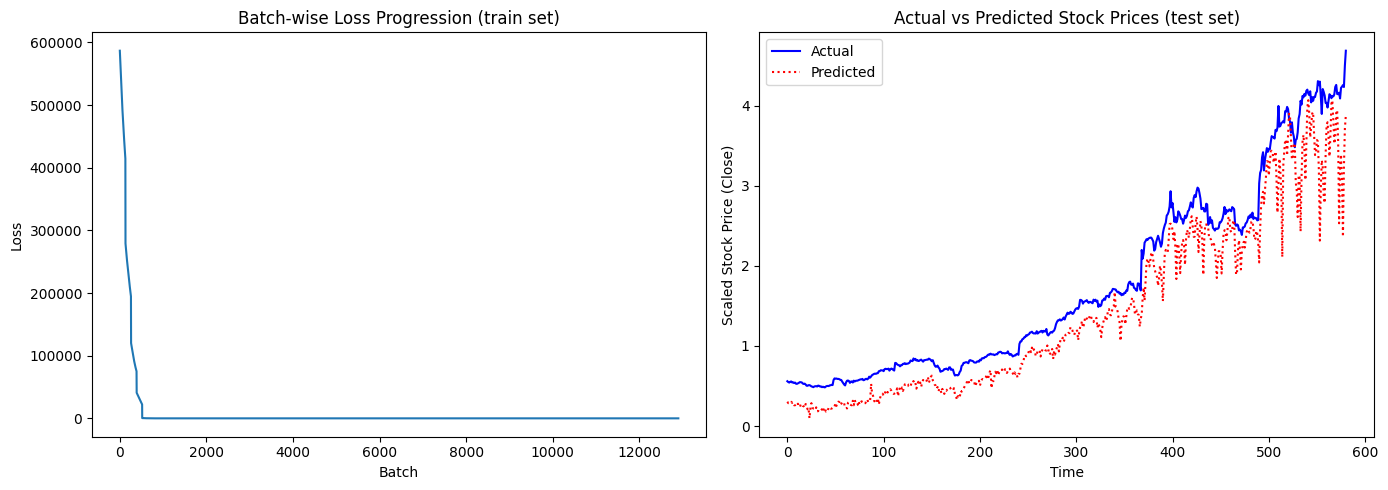

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0470 - mae: 0.1546
Fold-8 evaluation: 
[0.047390881925821304, 0.1457357555627823]


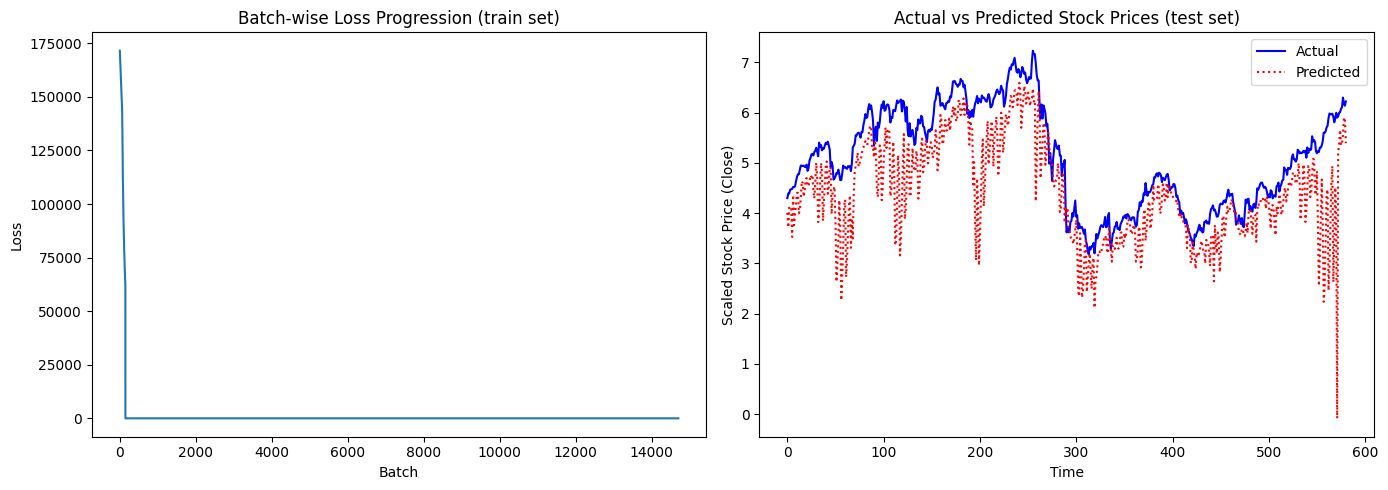

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0429 - mae: 0.1314
Fold-9 evaluation: 
[0.09928593039512634, 0.19905726611614227]


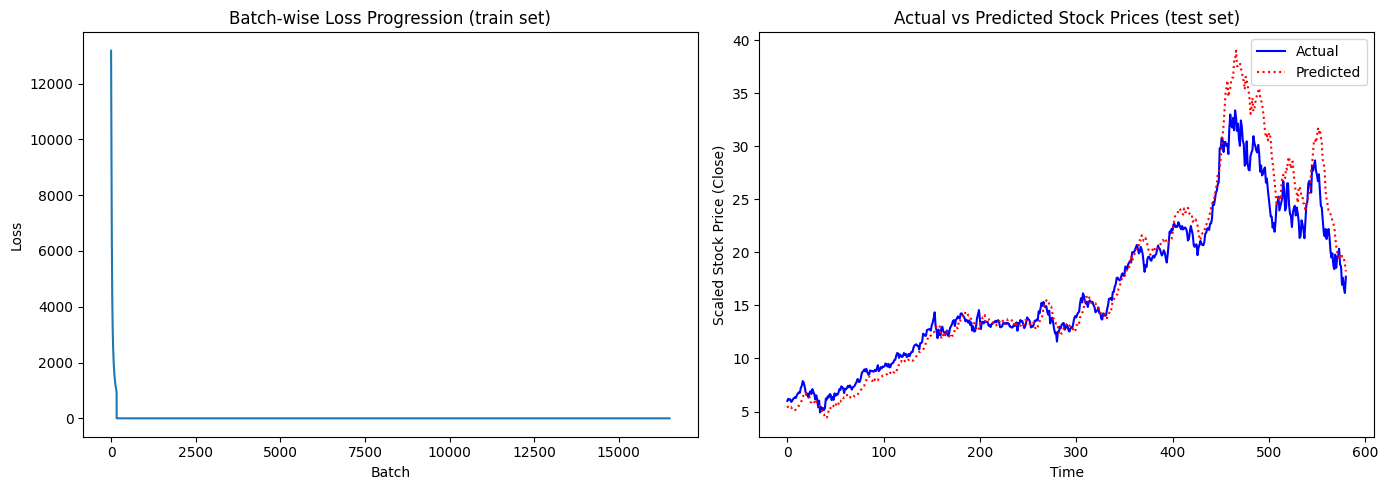

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0089 - mae: 0.0531
Fold-10 evaluation: 
[0.014121034182608128, 0.06839213520288467]


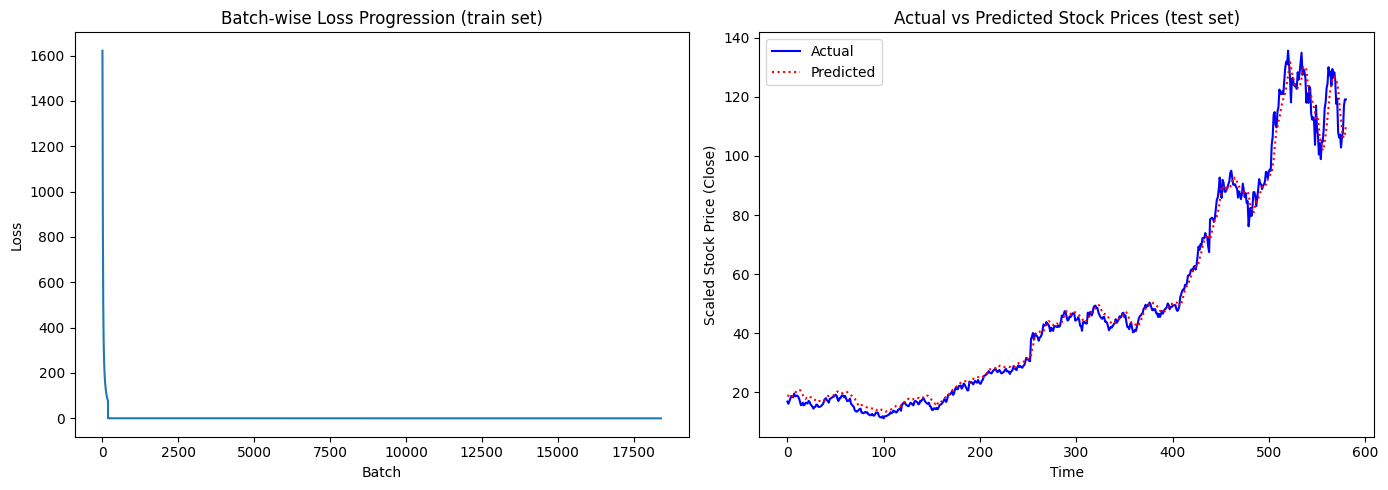

In [28]:
from keras.losses import Huber

timesteps = 5

lstm_kwargs = {
    'units': 50,
    'activation': "relu",
    'recurrent_activation': 'sigmoid',
    'return_sequences': False,
    'input_shape': ( timesteps, dfc.shape[1] - len(target_cols) ),
    'optimizer': Adam,
    'learning_rate': 0.0001,
    'dropout': 0.0,
    'recurrent_dropout': 0.0,
    'loss': 'mse'
}

lstm_model = train_model(
                model_init=lstm_init,
                splits=10,
                epochs=100,
                batch_size=32,
                timesteps=timesteps,
                verbose=0,
                **lstm_kwargs)

#### Discussion

Compared to the simple RNN training, our LSTM model was able to capture trends much more quickly and effectively!

For nearly all of the folds, the predictions were quite stable around the actual values.

The last couple folds had some stronger deviations from the actual curve in some segments, but in general kept to the trends rather well. 

With some additional fine-tuning, I can imagine this model performing exceptionally well, as the simple RNN didn't start adhering to the actual trends until the later folds.

### Bidirectional

Our final model we will be training is the Bidirectional RNN. While not exactly suited for time-series forecasting problems, I was interested to see how its performance differed from the other models;particularly the simple RNN, since we are using simple RNN layers for our foreward and backward layers.

The reason this type of model is not well-suited for time-series forecasting, is that it attempts to learn patterns both forewards and backwards through the series of data. Since our objective is to predict future values from past values, learning patterns in the reverse order may give this model some "bad habits" so to speak.

A `SimpleRNN` layer is passed to the `Bidirectional` constructor. This argument satisfied the `forward_layer` argument, and `backward_layer` is constructed automatically from the forward layer. The backward layer will have the exact same structure as the forward layer, but will traverse the dataset in reverse order.

In [25]:
def bidirectional_init(
        units: int,
        activation: str,
        return_sequences: bool,
        input_shape: tuple,
        optimizer,
        learning_rate,
        loss: str
):
    simple_rnn = Sequential()
    simple_rnn.add(Input(shape=input_shape))

    simple_rnn.add(Bidirectional(
        SimpleRNN(
            units=units,
            activation=activation,
            return_sequences=return_sequences
        )
    ))
    simple_rnn.add(Dense(len(target_cols)))
    simple_rnn.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=['mae'])
    return simple_rnn

#### Training

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1280 - mae: 0.2927
Fold-1 evaluation: 
[0.09445246309041977, 0.23883099853992462]


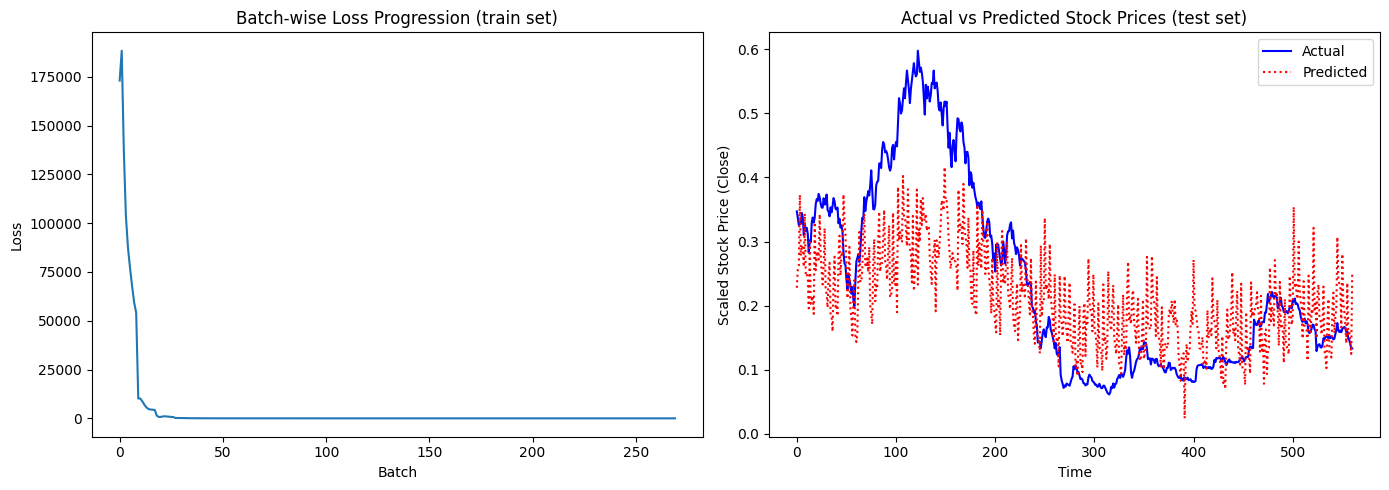

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0108 - mae: 0.0792
Fold-2 evaluation: 
[0.023408273234963417, 0.11826635897159576]


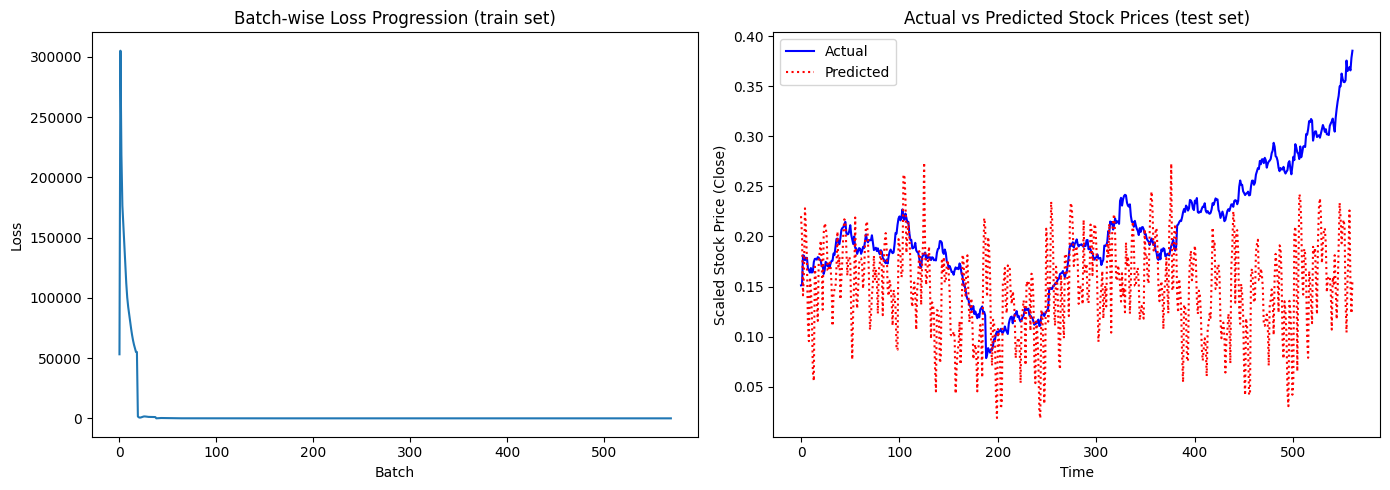

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4385 - mae: 0.6146
Fold-3 evaluation: 
[0.6508710980415344, 0.7517573237419128]


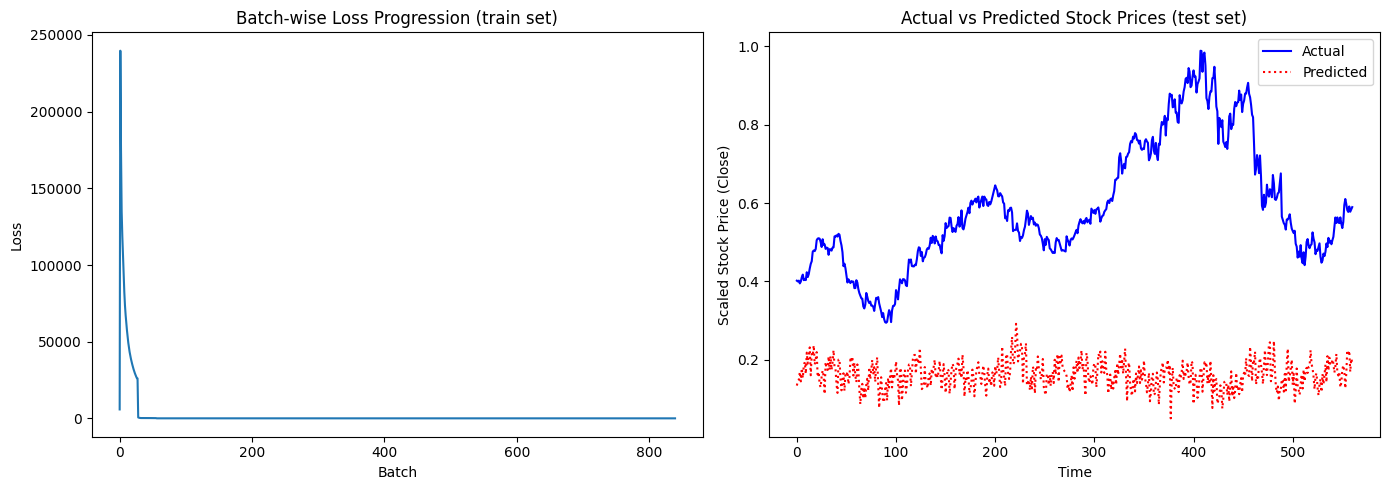

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0052 - mae: 0.0575
Fold-4 evaluation: 
[0.006173695903271437, 0.06284715235233307]


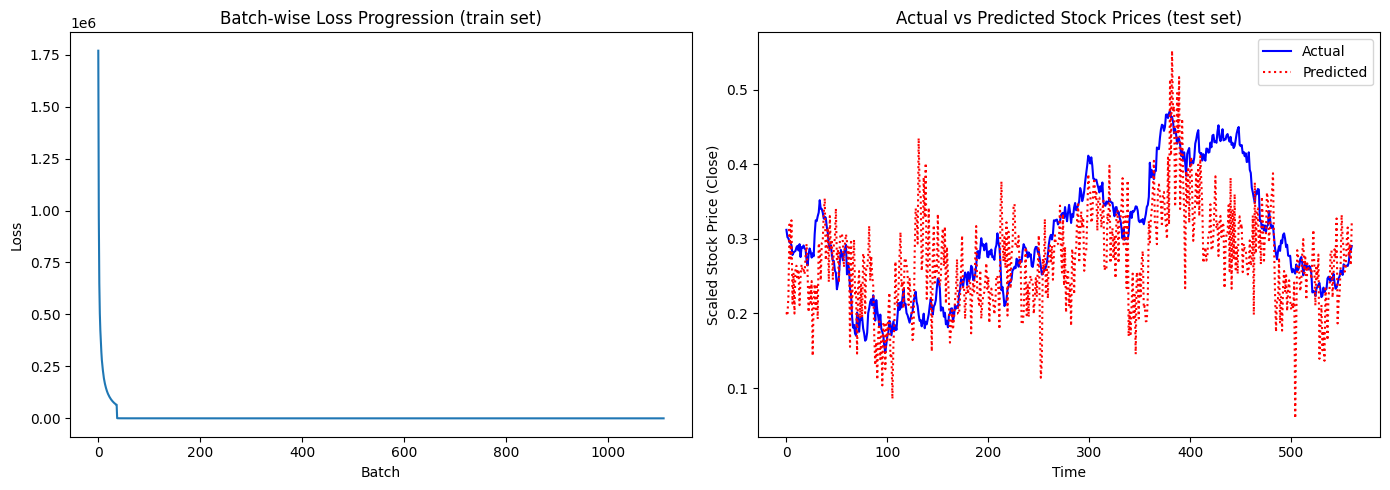

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0097 - mae: 0.0769
Fold-5 evaluation: 
[0.006531209219247103, 0.06227785721421242]


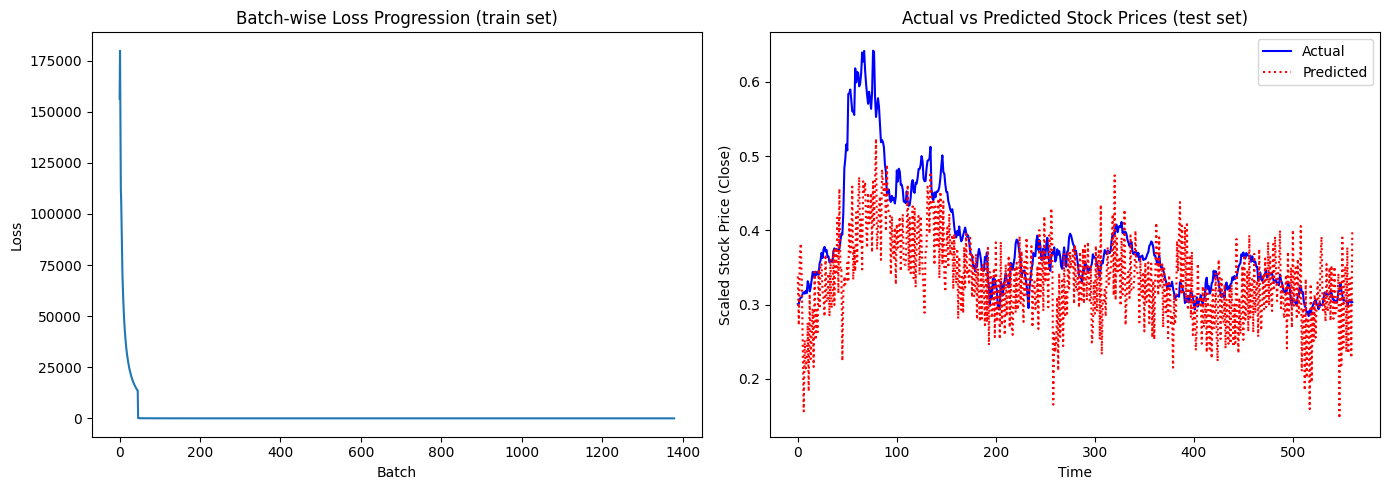

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - mae: 0.0473
Fold-6 evaluation: 
[0.0038750499952584505, 0.05021984875202179]


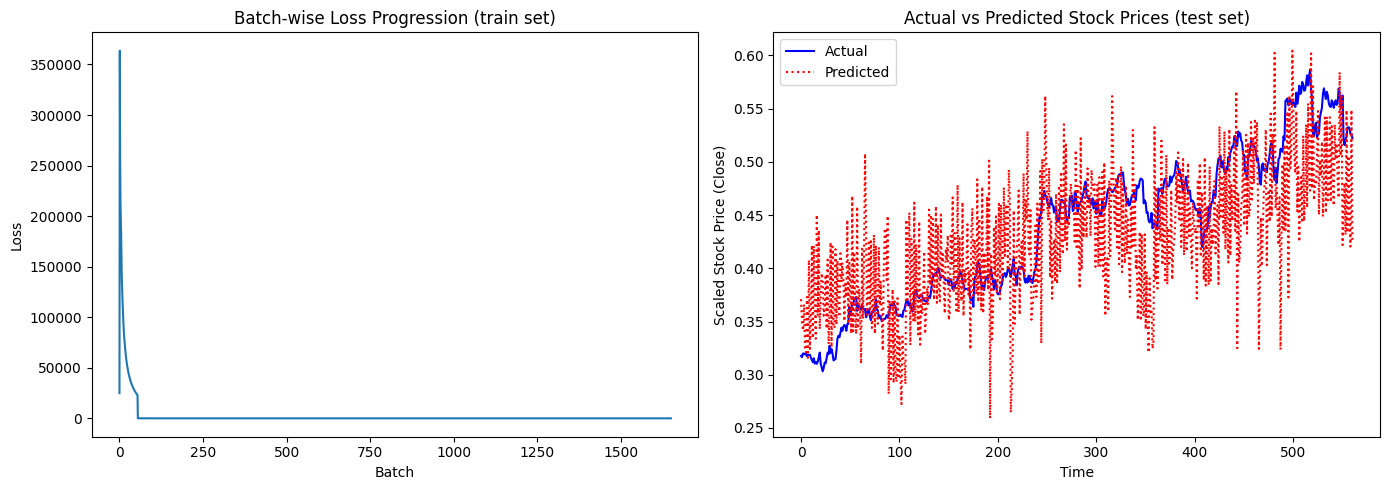

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4936 - mae: 0.4584
Fold-7 evaluation: 
[1.6331390142440796, 0.9788459539413452]


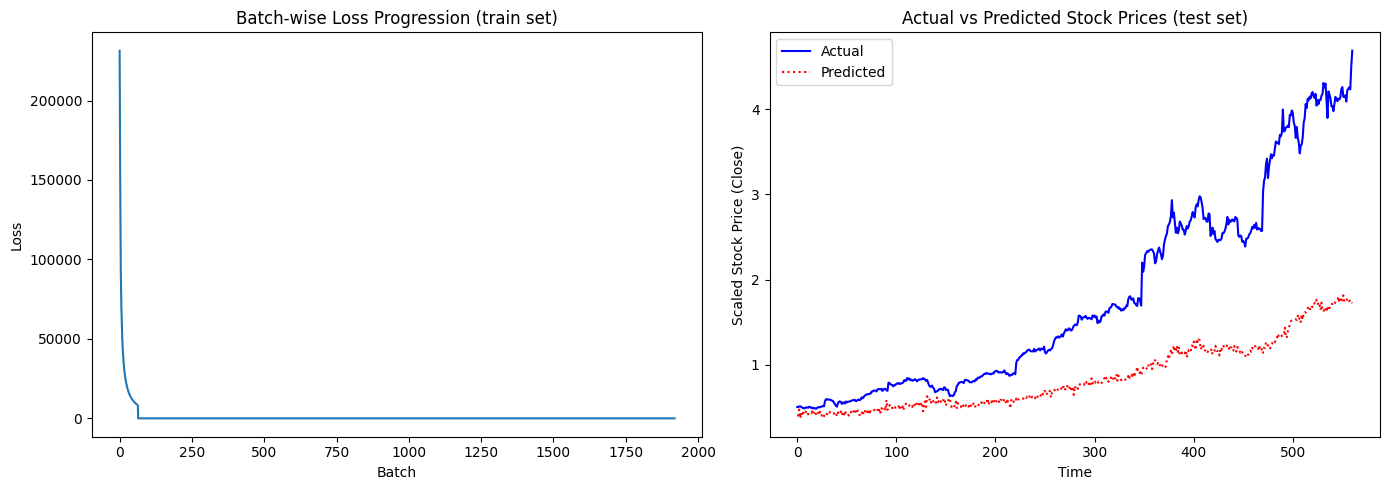

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.8513 - mae: 1.6788
Fold-8 evaluation: 
[2.787060260772705, 1.6590081453323364]


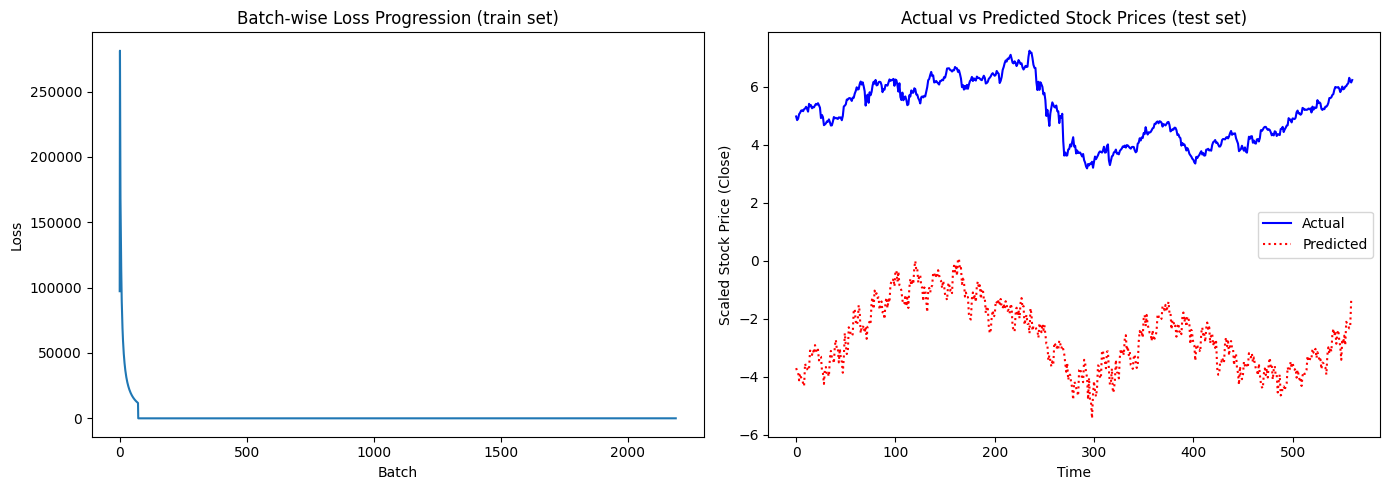

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0299 - mae: 0.1272
Fold-9 evaluation: 
[0.056558359414339066, 0.1686655580997467]


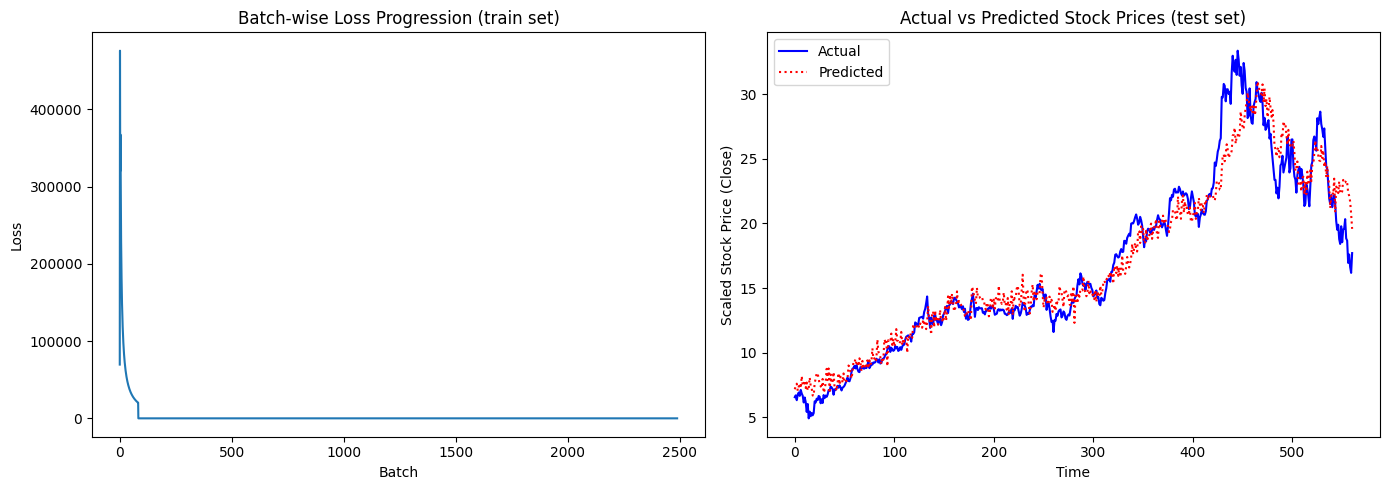

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0219 - mae: 0.0988
Fold-10 evaluation: 
[0.060173407196998596, 0.17275294661521912]


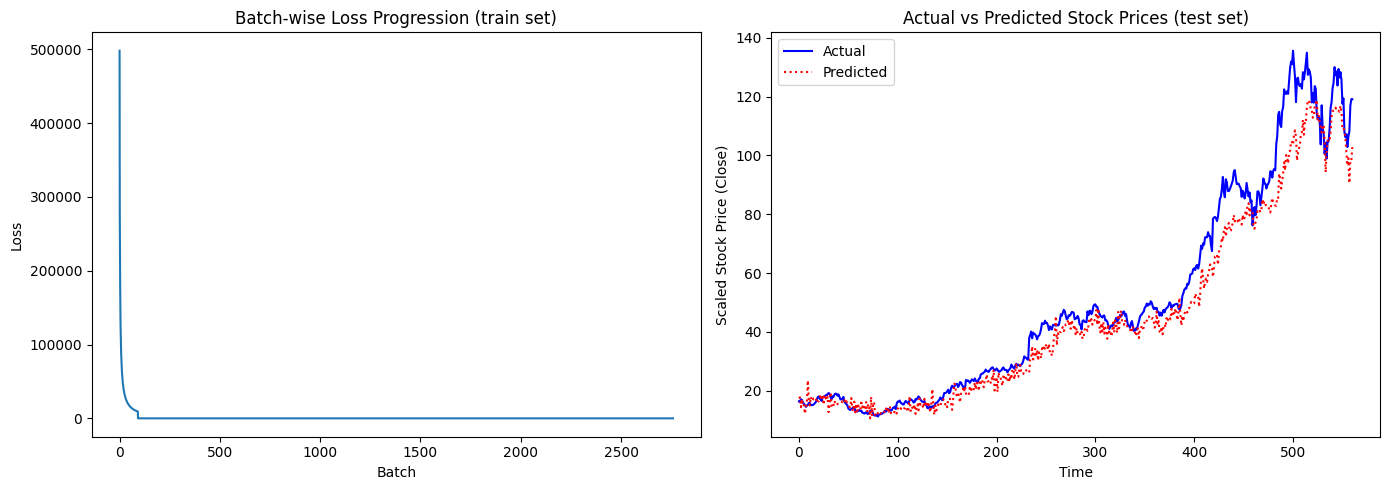

In [26]:
timesteps = 25

bidirectional_kwargs = {
    'units': 50,
    'activation': "relu",
    'return_sequences': False,
    'input_shape': ( timesteps, dfc.shape[1] - len(target_cols) ),
    'optimizer': Adam,
    'learning_rate': 0.01,
    'loss': 'mse'
}

bidirection_model = train_model(
                        model_init=bidirectional_init,
                        splits=10,
                        epochs=30,
                        batch_size=64,
                        timesteps=timesteps,
                        verbose=0,
                        **bidirectional_kwargs)

#### Discussion

While a bit more erratic, the bidirectional model seemed to perform fairly similarly to the simple RNN, though with slightly more error.

All-in-all, the bidirectional model was nearly as competent as the simple RNN, and though the predicted curves tend to match the general trends of the actual curves, we see a more severe rightward offset. This indicates a mild lag in the model's ability to recognize the trends as they occur (rising or lowering).

## Key Findings and Our Best Model

To review briefly the discussion sections for each model, here are the final errors (mean-squared and mean-absolute) for each model:

- Simple RNN : mean-squared error = 0.088 ; mean-absolute error = 0.216

- LSTM : mean-squared error = 0.014 ; mean-absolute error = 0.068

- Bidirectional : mean-squared error = 0.060 ; mean-absolute error = 0.173

Of course, these errors are for a single run of our training loop, and results may vary between executions of our training loop.

The LSTM model is the clear winner here, as it not only had substantially lower error, but it was able to follow very closely with the actual values throughout most of the folds. With that in mind, it would make sense to spend more time refining the LSTM model to get more consistent results.

The only drawback of our LSTM model, was that it required many more epochs to get results that were even comparable to the simple RNN. Because of this, the training time was more than twice as long compared to the simple RNN model.

One thing to note between the Simple RNN and the Bidirectional models is that while the Bidirectional model had lower errors, the simple RNN model seemed to follow the trend much more closely.

So, as per our objective for this notebook, we have determined that the LSTM model is the better choice out of a simple RNN, LSTM model, and Bidirectional RNN for time-series forecasting (with stock data).

## Possible Flaws, and Next Steps

The first thing to note with regard to possible flaws, is that we did not properly compare each of the models with regularization implemented (aside from the LSTM). Including this in a future series of experiments may provide a more complete picture of each model's performance. 

In general, being more thorough with our optimizations and tuning would be ideal; perhaps using GridSearchCV from scikit-learn as well.

As for our dataset, I think we had plenty of data to work with, but more feature engineering may be desirable, even though we increased the dimensionality of our dataset quite a bit when processing out date data. Due to this increased dimensionality, it may be possible to ignore some pricing features, such as `High` and `Low`. Experimenting with excluding some features may give some more insights into what is most valuable to the model to perform well.

On the note of analyzing feature importances, it would be interesting to try using Local Interpretable Model-agnostic Explanations (LIME) to gain some deeper insights into our model's predictions.

Ultimately though, I think deepening the models by adding more layers would be the most effective means of improving model performance. Adding more layers would allow for thinner layers (fewer units), potentially speeding up training. Most importantly, greater depth of our models would allow for capturing more subtle trends, potentially giving us greater predictive capabilities.